In [2]:
import pandas as pd

In [3]:
import os

In [4]:
file_path=os.path.join("data", "solar-measurements_togo-dapaong_qc.csv")

In [5]:
df = pd.read_csv("data/solar-measurements_togo-dapaong_qc.csv", encoding="latin1")

C:\Users\HP\AppData\Local\Temp\ipykernel_5012\3440172810.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/solar-measurements_togo-dapaong_qc.csv", encoding="latin1")


In [6]:
df.head()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,GHIrsi,Comments
0,yyyy-mm-dd hh:mm,W/m²,W/m²,W/m²,W/m²,W/m²,°C,%,m/s,m/s,m/s,°N (to east),°,hPa,1 or 0,mm/min,°C,°C,W/m²,NaN
1,2021-10-25 00:01,-1.3,0,0,0,0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0,24.7,24.4,0,NaN
2,2021-10-25 00:02,-1.3,0,0,0,0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0,24.7,24.4,0,NaN
3,2021-10-25 00:03,-1.3,0,0,0,0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0,24.7,24.4,0,NaN
4,2021-10-25 00:04,-1.2,0,0,0,0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0,24.7,24.4,0,NaN


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats



In [8]:
df.describe()

,Comments
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [9]:
df['Comments'].isna().sum(), len(df)


(np.int64(525601), 525601)

In [10]:
missing = df.isna().sum().sort_values(ascending=False)


In [11]:
threshold = 0.05 * len(df)
missing[missing > threshold]

Comments    525601
dtype: int64

In [12]:
from scipy.stats import zscore

In [16]:
columns_to_check = ['Timestamp', 'GHI', 'DNI', 'DHI','DHI','ModB','ModA','WS']  # Replace with actual column names


In [17]:
# Convert columns to numeric, force errors to NaN
for col in columns_to_check:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [18]:
# Now compute Z-scores
z_scores = df[columns_to_check].apply(zscore)

# Flag outliers
outliers = (np.abs(z_scores) > 3)
df['outlier_flag'] = outliers.any(axis=1)


In [19]:
df['Tamb'].unique()[:10]


array(['°C', '24.8', '24.9', '25', '25.1', '25.2', '25.3', '25.4', '25.5',
       '25.6'], dtype=object)

In [20]:
# Clean all key columns
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust', 'Tamb', 'TModA', 'TModB']

for col in key_columns:
    # Remove non-numeric characters and convert
    df[col] = df[col].astype(str).str.replace(r'[^-.\d]', '', regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [21]:
df_clean = df.copy()

for col in key_columns:
    median_val = df_clean[col].median()
    df_clean[col].fillna(median_val, inplace=True)


C:\Users\HP\AppData\Local\Temp\ipykernel_5012\2280799865.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(median_val, inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_5012\2280799865.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

In [22]:
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'], format='%Y-%m-%d %H:%M', errors='coerce')

In [23]:
print(df_clean['Timestamp'].isna().sum())  # Count unconverted values

525601


In [24]:
df_clean['Timestamp'] = df_clean['Timestamp'].astype(str).str.strip()
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'], errors='coerce')

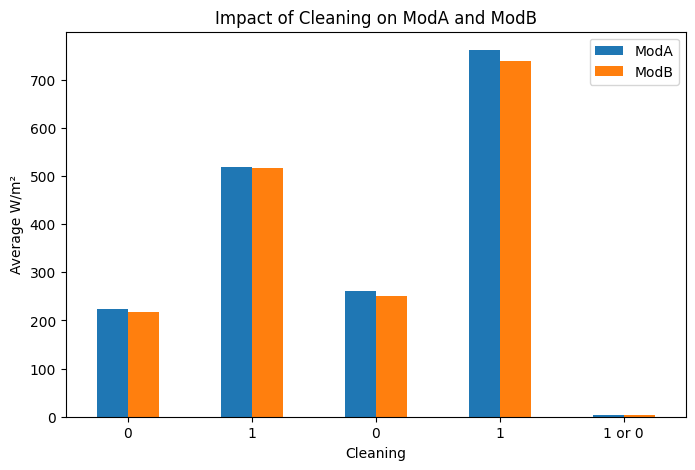

In [25]:
df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().plot(kind='bar', figsize=(8,5))
plt.title('Impact of Cleaning on ModA and ModB')
plt.ylabel('Average W/m²')
plt.xticks(rotation=0)
plt.show()


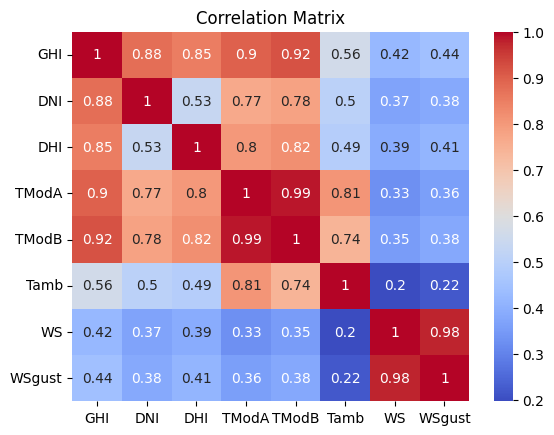

In [26]:
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'WS', 'WSgust']
sns.heatmap(df_clean[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


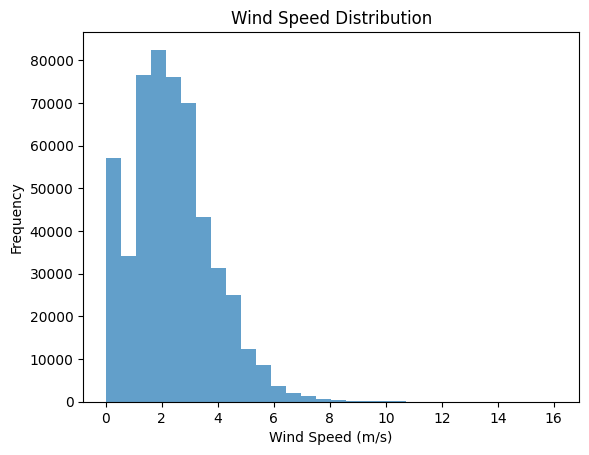

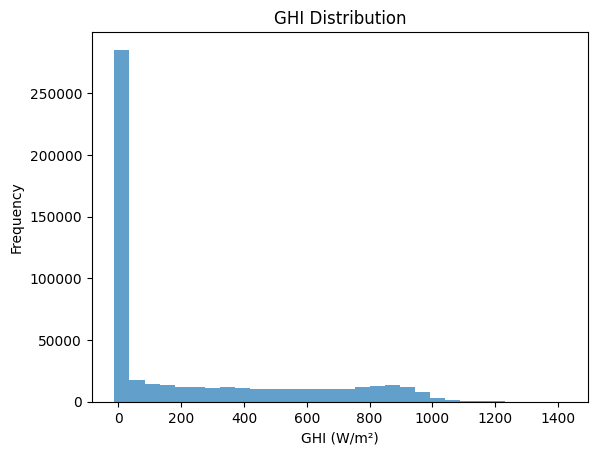

In [27]:
# Histogram of wind speed
df_clean['WS'].plot(kind='hist', bins=30, alpha=0.7, title='Wind Speed Distribution')
plt.xlabel('Wind Speed (m/s)')
plt.show()

# Histogram of GHI
df_clean['GHI'].plot(kind='hist', bins=30, alpha=0.7, title='GHI Distribution')
plt.xlabel('GHI (W/m²)')
plt.show()


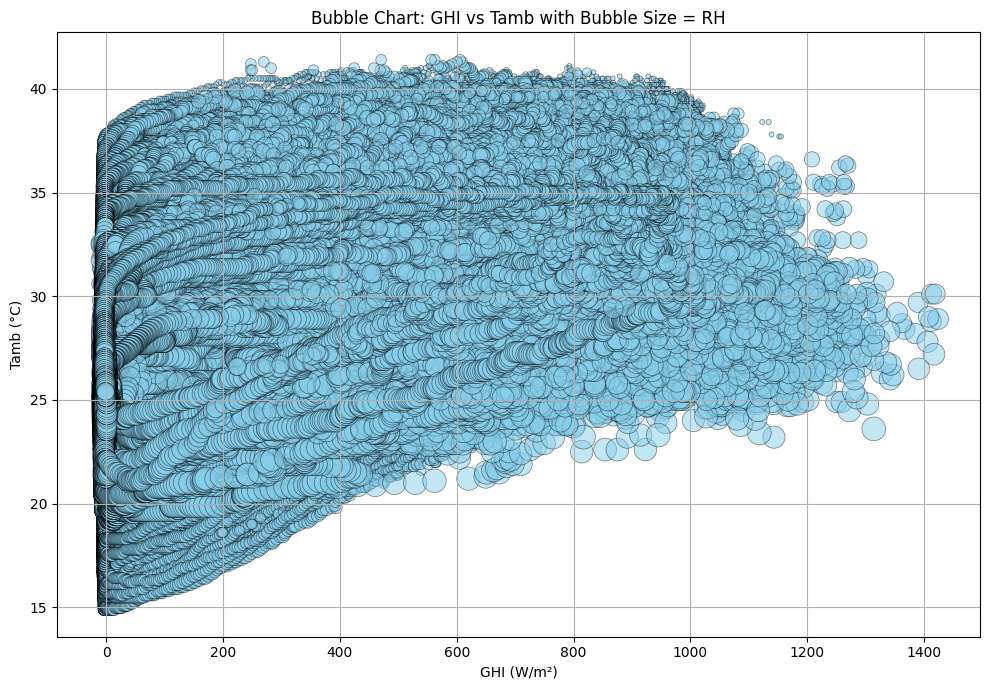

In [29]:
df['GHI'] = pd.to_numeric(df['GHI'], errors='coerce')
df['Tamb'] = pd.to_numeric(df['Tamb'], errors='coerce')
df['RH'] = pd.to_numeric(df['RH'], errors='coerce')

# Drop rows where any of these key columns are NaN
df_clean = df.dropna(subset=['GHI', 'Tamb', 'RH'])

# Ensure equal lengths and correct types
ghi = df_clean['GHI'].astype(float)
tamb = df_clean['Tamb'].astype(float)
rh = df_clean['RH'].astype(float)

# Create the bubble chart
plt.figure(figsize=(10, 7))
plt.scatter(
    ghi,
    tamb,
    s=rh * 3,  # Scale bubble size
    alpha=0.5,
    c='skyblue',
    edgecolors='black',
    linewidth=0.5
)

# Add labels and title
plt.xlabel('GHI (W/m²)')
plt.ylabel('Tamb (°C)')
plt.title('Bubble Chart: GHI vs Tamb with Bubble Size = RH')
plt.grid(True)
plt.tight_layout()

# Show the chart
plt.show()


In [30]:
df_clean.to_csv('data/togo_dapaong_clean.csv', index=False)
